In [18]:
import numpy as np
import pandas as pd
from settings import settings
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

## Parameter

In [19]:
ret_type = "alpha"
method = "pearson"
linkage_method = "ward"
# Clustering Number
k = 13
direction_bars=True
char_info=None

## Get Data

In [20]:
regional_pfs = pd.read_parquet("result/regional_pfs.parquet")
# regional_pfs = pd.read_parquet("result/regional_mkt_ret.parquet")

In [21]:
# US Clusters -----------
clusters = regional_pfs[
    (regional_pfs['region'] == settings["hcl"]["region"]) &
    (regional_pfs['eom'].dt.year >= settings['hcl']['start_year'])
]


# Calculate Correlation Matrix

In [22]:
data_copy = clusters.copy()

In [23]:
if ret_type == "raw":
    data_copy["ret_hcl"] = data_copy["ret"]
elif ret_type == "alpha":
    data_copy["ret_hcl"] = (
        data_copy
        .groupby("characteristic", group_keys=False)[["ret", "mkt_vw_exc"]]
        .apply(lambda x: x["ret"] - x["mkt_vw_exc"] * x["ret"].cov(x["mkt_vw_exc"]) / x["mkt_vw_exc"].var())
    )

In [24]:
data_wide = data_copy.pivot(index="eom", columns="characteristic", values="ret_hcl")

In [25]:
cor_matrix = data_wide.corr(method=method)

## Hierarchical Clustering

In [26]:
dist_mat = pdist(1-cor_matrix)

In [27]:
hcl = linkage(dist_mat, method=linkage_method)

In [28]:
hcl_labels = pd.DataFrame(
    {
        "characteristic": cor_matrix.index, 
        "hcl": cut_tree(hcl, n_clusters=k).flatten() + 1
    }
)

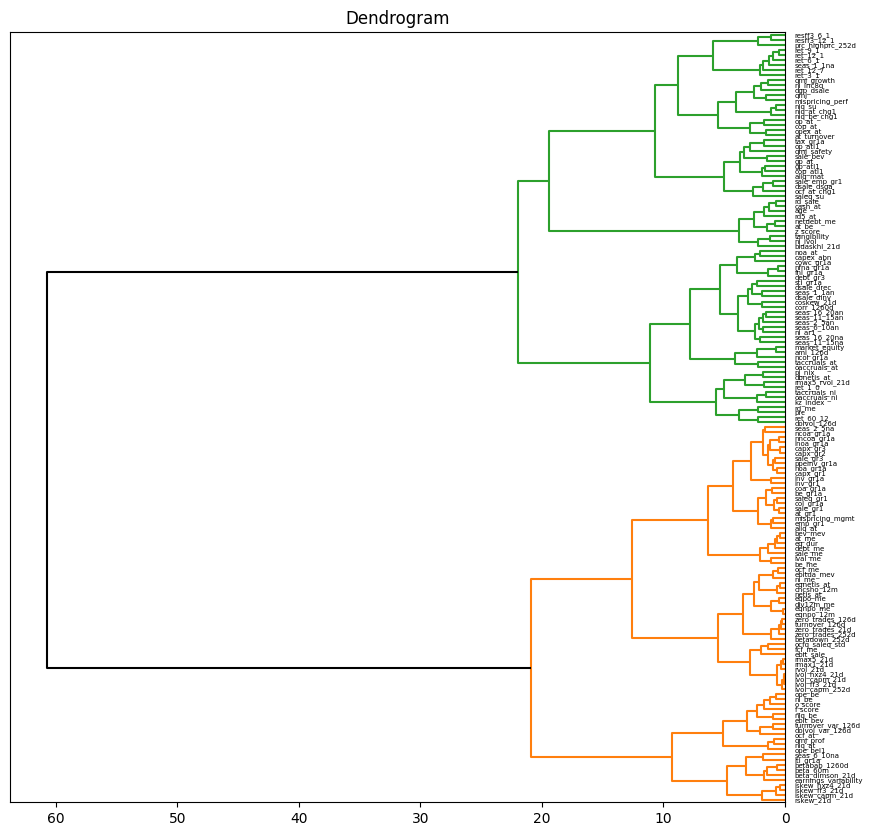

In [29]:
# Assign colors for the dendrogram
hcl_col = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808000'] * (k // 8 + 1)

# Plot dendrogram
plt.figure(figsize=(10, 10))
dendro = dendrogram(hcl, labels=cor_matrix.index, color_threshold=None, above_threshold_color='black', orientation='left')
plt.title("Dendrogram")
plt.show()


In [30]:
clusters_result = {
        'cor': cor_matrix,
        'labels': hcl_labels,
        'dend': dendro
    }

In [31]:
## Clustering Labels

In [32]:
if settings['weighting']['us'] == 'vw_cap' and settings['hcl']['k'] == 13 and settings['hcl']['region'] == 'us' and settings['hcl']['start_year'] == 1975:
    clusters_result['labels']['hcl_label'] = clusters_result['labels']['hcl'].replace({
        1: "Low Leverage",
        2: "Investment",
        3: "Size",
        4: "Value",
        5: "Quality",
        6: "Low Risk",
        7: "Debt Issuance",
        8: "Seasonality",
        9: "Accruals",
        10: "Profitability",
        11: "Profit Growth",
        12: "Short-Term Reversal",
        13: "Momentum"
    })
else:
    clusters_result['labels']['hcl_label'] = clusters_result['labels']['hcl'].astype(str)


In [38]:
# Cluster를 보면 맞게 된것을 볼 수 있다. 
tmp = clusters_result['labels'].copy()
tmp[tmp["hcl_label"] == "Momentum"]

,characteristic,hcl,hcl_label
113,ret_12_1,13,Momentum
114,ret_12_7,13,Momentum
116,ret_3_1,13,Momentum
118,ret_6_1,13,Momentum
119,ret_9_1,13,Momentum
137,seas_1_1na,13,Momentum


## Output

In [39]:
cluster_labels = clusters_result['labels'].drop(columns=['hcl'])

In [40]:
cluster_labels

,characteristic,hcl_label
0,age,Low Leverage
1,aliq_at,Investment
2,aliq_mat,Size
3,ami_126d,Value
4,at_be,Low Leverage
...,...,...
148,turnover_var_126d,Profit Growth
149,z_score,Low Leverage
150,zero_trades_126d,Seasonality
151,zero_trades_21d,Seasonality


In [41]:
cluster_labels.to_parquet("result/cluster_labels.parquet")